In [1]:
import os



import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import models

In [2]:
import os
import time

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchcam.utils import overlay_mask

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


In [4]:
font = ImageFont.truetype('arial.ttf', 50)

In [5]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [6]:
idx_to_labels

{0: 'alligator apple',
 1: 'apple',
 2: 'avocado',
 3: 'banana',
 4: 'barberry',
 5: 'bayberry',
 6: 'bell pepper',
 7: 'black berry',
 8: 'black cherry',
 9: 'blueberry',
 10: 'bottle gourd',
 11: 'cantaloupe',
 12: 'carambola',
 13: 'cherry',
 14: 'coconut',
 15: 'corn kernel',
 16: 'custard apple',
 17: 'dragonfruit',
 18: 'durian',
 19: 'eggplant',
 20: 'fig',
 21: 'grape',
 22: 'jackfruit',
 23: 'jalapeno',
 24: 'kiwi',
 25: 'lemon',
 26: 'lime',
 27: 'longan',
 28: 'macadamia',
 29: 'mango',
 30: 'orange',
 31: 'papaya',
 32: 'pea',
 33: 'peanut',
 34: 'pear',
 35: 'persimmon',
 36: 'pineapple',
 37: 'pomegranate',
 38: 'pumpkin',
 39: 'saguaro',
 40: 'strawberry',
 41: 'tomato',
 42: 'watermelon',
 43: 'zucchini'}

In [77]:
import torch
from ensemble_model import WeightedEnsembleModel
model = torch.load('checkpoint/best-0.936.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)

In [78]:
from torchcam.methods import CAM
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = CAM(model)

In [79]:
from torchvision import transforms

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [80]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
cap.release()


cv2.destroyAllWindows()


In [81]:
img_bgr.shape

(480, 640, 3)

In [82]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [83]:
img_pil = Image.fromarray(img_rgb)

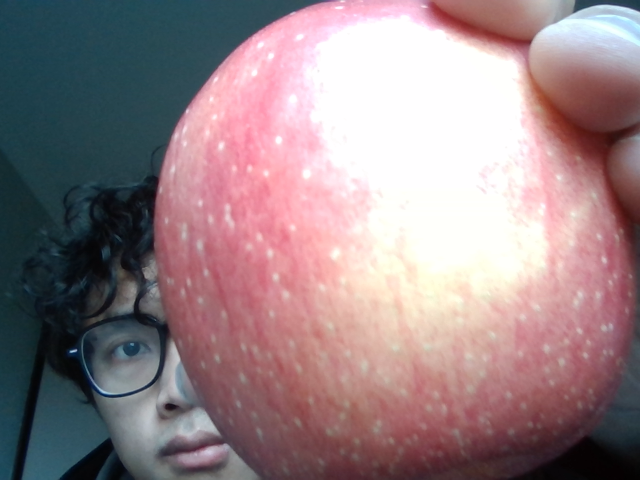

In [84]:
img_pil

In [85]:
# 可视化热力图的类别ID，如果为 None，则为置信度最高的预测类别ID
# show_class_id = 761
show_class_id = None

In [86]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_top1 = torch.topk(pred_logits, 1)
pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()

In [87]:
if show_class_id:
    show_id = show_class_id
else:
    show_id = pred_id
    show_class_id = pred_id

In [88]:
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

RuntimeError: The size of tensor a (2048) must match the size of tensor b (2560) at non-singleton dimension 1

In [75]:
draw = ImageDraw.Draw(result)

# 在图像上写中文
text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])

# 文字坐标，中文字符串，字体，rgba颜色
draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))

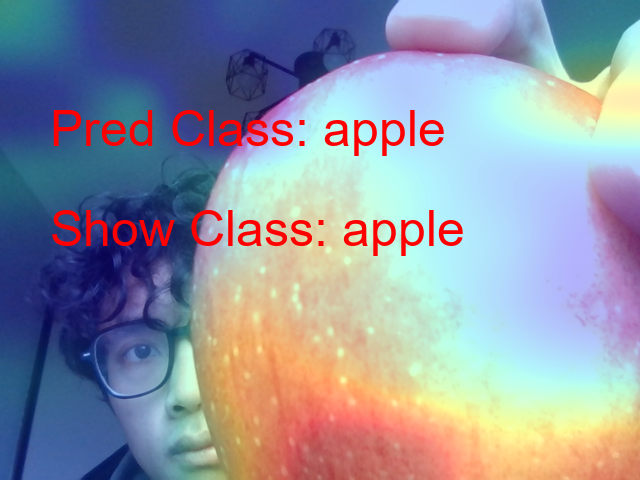

In [76]:
result

In [55]:
def process_frame(img, show_class_id=None, Chinese=True):

    
    img_bgr = img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb) 
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device) 
    pred_logits = model(input_tensor) 
    pred_top1 = torch.topk(pred_logits, 1)
    pred_id = pred_top1[1].detach().cpu().numpy().squeeze().item()
    

    if show_class_id:
        show_id = show_class_id
    else:
        show_id = pred_id
        show_class_id = pred_id
        
    activation_map = cam_extractor(show_id, pred_logits)
    activation_map = activation_map[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

    draw = ImageDraw.Draw(result)

    text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_id])
    text_show = 'Show Class: {}'.format(idx_to_labels[show_class_id])

    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    draw.text((50, 200), text_show, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(result)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return img_bgr

In [56]:
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame) # 类别：最高置信度预测类别
    # frame = process_frame(frame, show_class_id=11) # 类别：猕猴桃
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()